In [3]:
from classify import *

from flask import Flask, request, jsonify

import base64
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

from skimage import measure
from skimage import io
from skimage.transform import resize
from skimage.filters import inverse

from PIL import Image
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.autograd import Variable

In [4]:
#Defining general variables.
Momentum = 0.9
Batch_size = 50
Epochs_number = 5
Learning_rate = 0.001
np.random.seed(3)

#Building the network.
class Neural_Network(nn.Module):
    
    #Definition.
    def __init__(self):
        super(Neural_Network, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=0)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.Losses = []
        self.Accuracies = []
     
    #Forward function.    
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        
        return x 
    
    #Training function.
    def train_net(self, Training_set, Epochs_number, Learning_rate, Momentum):
        
        Loss_function = nn.CrossEntropyLoss()
        Optimizer = optim.SGD(net.parameters(), lr = Learning_rate, momentum = Momentum)

        for epoch in range(Epochs_number):

            Current_loss = 0.0
            Current_accuracy = 0.0
            
            for batch_index, training_batch in enumerate(Training_set, 0):
                
                Inputs, Labels = training_batch
                Inputs, Labels = Variable(Inputs), Variable(Labels)

                Optimizer.zero_grad()
                Outputs = self.forward(Inputs)

                Loss = Loss_function(Outputs, Labels)
                Current_loss += Loss.item()
                
                Loss.backward()
                Optimizer.step()
                
                Total_pred = 0
                Correct_pred = 0
                
                for data in training_batch:
                    Images, Labels = training_batch

                    Outputs = self.forward(Variable(Images))
                    Dummy, Pred_labels = torch.max(Outputs.data, 1)
                    
                    Correct_pred += (Pred_labels == Labels).sum().item()
                    Total_pred += Pred_labels.size(0)
                    
                Current_accuracy += (100 * Correct_pred)/Total_pred

                if batch_index % 300 == 299:
                    
                    print('[Epoch: %d Batch: %5d] loss: %.3f' % 
                          (epoch + 1, batch_index+1, Current_loss/300)) 
                    
                    self.Losses.append(Current_loss/300)
                    self.Accuracies.append(Current_accuracy/300)

                    Current_loss = 0.0
                    Current_accuracy = 0.0
      
        print('Training finished')

In [5]:
class ClassifyImage(object):
    percentage_treshold = 0.035
    output_size = 28
    color = list(mcolors.BASE_COLORS.values())
    
        
    def __init__(self):
        self.crop_list = []
        self.cropped_images = []
        
    def set_img(self, img):
        self.img = img #[:, :, 0]
    
    def show_original_img(self):
        plt.imshow(self.img, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.show()
        
    def get_shape(self):
        return self.img.shape
        
    def crop_image(self, img, y_min, height, x_min, width):
        y_min = int(y_min)
        height = int(height)
        x_min = int(x_min)
        width = int(width)

        return img[y_min:y_min+height , x_min:x_min+width,]
    
    
    def find_img_contours(self, show_output = False):
        self.countours = measure.find_contours(self.img, 1, fully_connected="high", positive_orientation="high")
        
        self.crop_list = []
        
        for n, contour in enumerate(self.countours):

            # Get extreme values of the contours
            self.y_min, self.x_min = np.min([contour], axis=1)[0]
            self.y_max, self.x_max = np.max([contour], axis=1)[0]

            # Compute the width and height a the box surrounding the countrous
            self.width = self.x_max - self.x_min
            self.height = self.y_max - self.y_min
            
            if(show_output):
                plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
                plt.imshow(self.img, cmap=plt.cm.gray_r, interpolation='nearest')

                plt.axvline(x=self.x_min, color=self.color[n], linestyle='--')
                plt.axvline(x=self.x_min + self.width, color=self.color[n], linestyle='--')
                plt.axhline(y=self.y_min + self.height, color=self.color[n], linestyle='--')
                plt.axhline(y=self.y_min, color=self.color[n], linestyle='--')

            self.crop_list.append({'y_min': self.y_min, 'height': self.height, 'x_min': self.x_min, 'width': self.width})

        print('Number of contours found: {0}'.format(len(self.countours)))
        
        if(show_output):
            plt.show()
        
        
    def apply_cropping(self, show_output = False):
        # Get size of the original image
        original_size_y, original_size_x = self.get_shape()
        self.count_dropped = 0

        self.find_img_contours(show_output)
        
        for crop in self.crop_list:    
            
            self.precentage = (crop['height']*crop['width'])/(original_size_y*original_size_x)
            
            # Crop image
            self.cropped_image = self.crop_image(self.img, crop['y_min'], crop['height'], crop['x_min'], crop['width'])

            if(self.precentage < self.percentage_treshold):
                self.count_dropped += 1
                continue

            print('  -  Percentage of crop / entire canvas {0:.2%}'.format(self.precentage))
            
            if(show_output):
                # Plot cropped image
                plt.imshow(self.cropped_image,cmap=plt.cm.gray_r, interpolation='nearest')
                plt.title('Cropped number')
                plt.show()

            # Prepend and append white vertical white lines on each side to make it a square
            if(crop['height'] > crop['width']):
                ny,nx = self.cropped_image.shape

                # Divide the differences between height and width by 2 since there are two lines added each iteration
                for x in range(0, int((crop['height']-crop['width'])/2)):

                    # Add two lines, one on each side
                    self.cropped_image = np.c_[np.zeros(int(ny)), self.cropped_image, np.zeros(int(ny))]

            # Prepend and append white horizontal white lines on each side to make it a square
            if(crop['width'] > crop['height']):
                ny,nx = self.cropped_image.shape

                # Divide the differences between height and width by 2 since there are two lines added each iteration
                for x in range(0, int((crop['width']-crop['height'])/2)):
                    # Add two lines, one on each side
                    self.cropped_image = np.append(np.zeros([1, int(nx)]), self.cropped_image, axis=0)
                    self.cropped_image = np.append(self.cropped_image, np.zeros([1, int(nx)]), axis=0)
    
            if(show_output):
                # Plot cropped squared image
                plt.imshow(self.cropped_image,cmap=plt.cm.gray_r, interpolation='nearest')
                plt.title('Make corpped image a square')
                plt.show()

            
            self.cropped_images.append(self.cropped_image)
            # Classify resized image
            #cropped_resized_reshaped = np.array(cropped_image_resized).flatten().reshape(1, -1)
            #print('Number classified: {0}'.format(classifier.predict(cropped_resized_reshaped)[0]))


        print('{0} contours dropped'.format(self.count_dropped))
        
        
    def classify(self):
        net = torch.load('tensor.pt')

        print(len(self.cropped_images))
        
        self.apply_cropping(show_output=True)
        
        for image in self.cropped_images:
            image = Image.fromarray(image)
            
            transfrom = transforms.Compose([
                transforms.Grayscale(),
                transforms.Resize(self.output_size - 10),
                transforms.CenterCrop(self.output_size),
                transforms.ToTensor(),
            ])

            img_tensor = transfrom(image)
            
            plt.imshow(np.array(img_tensor)[0, :, :],cmap=plt.cm.gray_r, interpolation='nearest')
            plt.title('Image used for classification')
            plt.show()
            
            img_tensor.unsqueeze_(0)        
            Outputs = net.forward(Variable(img_tensor))
            Dummy, Predicted_labels = torch.max(Outputs.data, 1)
    
            print('Classified: {0}'.format(Predicted_labels.numpy().max()))

## Copy image output from online and paste here

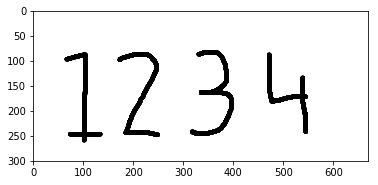

In [7]:
image_base = 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAp4AAAEsCAYAAABqnLNwAAAAAXNSR0IArs4c6QAAKVlJREFUeAHt3U/sLdddGPBAsNOmCgKpStxNl1SqREgpCycSgmbTSlTqpkipsngkSrrtAqliyQq1uDGNTUGIDVUVqjZNgtSmiyrh9xwHJ4gWhECC8C91ojapnbpOcBIb/6Hnm7zxu75v5s733Pk/8znSeffemTPnz+ecM29+c2fmvu51AgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIEqgXeU1E+X+JclvnLnNd7PEaO8L5T4gRK/s0SBAAECBAgQIEBgZwIPlvZ8ucQ5Di5rynjrzpw1hwABAgQIECBwSIG1HmyeH5jelN75rkP2kEYTIECAAIENCzxQ6v5HJX6zxLm+Qo1yvlhifHV6f4nCcgLx1fV7SvxsiecHd2v//LVS5+8oUSBAgAABAvcIxAHGwyU+U+L5f2hxIBLXjz1U4htKFKYXuFWKOO+HJT7HAa/r9qbv77YS4qDtV0tcot/HLNPBZ1vvTrfsvpL1O0uM/fnn7sR4H8tinUCAAIHZBYbciPBkqa0DkXG7bImzmrUHFv7DGrfPM7m9qySq7ae1pnfwmenx4WnC+cMXxk2s0xfDneVAgEBCYMxrwx5NlCdJv8CtkmStBwpt9fpoqa/r9vr7dawUT2xsfLSNmdNl/ngZa2R05/PuxJiJNAIBAgRGEYivy2+X+KUSp7we8LmSv1An8KaS/P0l/laJp/8Zb/H9z5Q2OAAtCBOHb5T8tzg+uur8YmmPs23TDprPJ8ZMpBEIECAwSCAOAj5SYtcOf4rlgyp8kI3jDM/HS/xfJU7RB0vm+dXSJgcRBWHCsLcDz2a8ulRnukGTOeEQaQQCBAhUC8R1gXHBeLMzn/u1usIH2WDpfpl7HDj4nG5g7+2r9mZsfmU6ssPn3Bj3vR4eCgABAjmBuE4zvkbv26nMsT5X42OkWlO/zNH352U4+JxmnL/ryrkeD5WPMTl1+P5SwPlYyH5+ZOrKHTT/rP9BeTSbAIGMQHyNHl/XZncoc6XL1H3vaX5qhf0yV/+flvP03jt6ofbFAf2HkmNsroPNc4qo4+lYqHnvOuFzzeGfs/7DS5IDAQK7EJjr5qDszulSul2AX9mIt5XtLtkccd2nrrS02WWBuB7yfSX+ZonNNZ8vl/cxxuKAPx6NtnS49uAznpIgjCuQ3feMW6rcCBDYlED8x/KeEn+7xOxOYw3pNoU8UmXjDM3Nwv10a6S2nGcTBw9xw9CQsRVfvQrHFLj24NNZz3HHS3b+jluq3AgQ2IxA7KyzX6VldyhzpdsM8kgVjb6KnwCcyzfKibtP45eD4iczHyhx6hAHAfGopCFtdPA5dS+tN/+YI/HIpJrx84n1NmeTNcvab7JxKk2AwHCBa28eyO5cMunOrw3LbBNpjhb+Z2lw1mZoulsL48YB6JDHc8Xd2HEQIhxPIB4hVjv+j6c0XYuz9tPVQM4ECKxaYO7HpWSuDbPjunfI/FhZlHW5Jl1cu/d7Jb7l3qIXXXLNQUTT/scWrbnClxSoHTe3lqzszspu5l/f686arTkECGQFmpsF+nYS167/tVKR2muosmVl27iHdP+9NCLrkk0Xef7TEt+0cqA4c5lt03m6D668bao3nUDcOHQ+Hi59nq4mx8r5kvHpumOpaC0BAq8KTHHg+WzJPR6/VHvA2VTqdOd06X2T/givlxyy64b2y5LOQw4+rx2HS7ZX2cMFot+zcyPSvXl4kXKoMIdFgMBBBcb8qj1+xWiMG1Cy/1kcqcuyJm3pxuqXpb2vfYTUp5euuPIXE/jjUnLbnGhbFmmF4QJttm3LhpckBwIENikw5Oaip0qLH5yg1W07qbZlExS92ix/p9SszaBt2XMl7RT9sgacuG6zrc19y964hsqrw+wCcRazb2ycrnd2fHgXnXpeej+8JDkQILBJgfgKM/s4pXi0Tvxc5u0S7y9xqnBpZ3W6bqry15jvPy6VOm171/sjPEro15MWp0YvlG1irAvHEzgdB33v47pQYZhAn3GzflgptiZAYNMC8QD595b4mRKbaz7nOshsg2t2TH2vbdvuedlPl8Z1mTxT1h3pwCrGapdF1/KHyjbC8QRulSZ3jYm25c56DhsjbaZty4aVYmsCBAiMKNC2k2pbNmKRm8nqH5Sa/vsSv15iPEz+35b490s84n+Wtdd8xllP4ZgCbfuPrmWuCR42Rrpcz5cPK8XWBAgQGFHgfAfV9XnEImW1UYHHS727xkfb8ni+o3A8gfh1orbx0LXsiH/IjTUqukzPl49VnnwIECAwWOB8B9X1eXBBMti8QBwgdI2PtuU3m2+xBlwjYJxco3bdNm3zrm3ZdbnbigABAhMItO2k2pZNULQsNyjwSKlz2/hoW/b8BtunyuMI1PwE65+PU+Qhc2mbd23LDomj0QRC4Eg3ZGylx2MnlQn6LqN0jDRxM1x2PGTTHUPuOK2Ms54vVjT39SVtjCuhTsD+u85L6gMKxB3dAgEC2xZ4bNvVV/sZBF4qZXy6opy/XZFWUgIECBDYsEDb1zJtyzbcRFUfWSBuGmobI23LRi5adhsSqLnW8/0bateaqto259qWranO6kJgVgFnPGflVhiBSQRqvkKdpAIy3YRAnPXMhr3++le2/dIRIDCRgAPPiWBlS4AAgQ0LvH3DdVd1AgRWLOBGg/V1Tnwtkwn6LqN0nDTGzXH6ekhLs+MkyrCPqZfO+rKtt7XFTgSc8dxJR2oGAQIEEgJ/kEgjCQECBCYTcOA5Ga2MCRAgsDqBz6yuRipEgMChBBx4Hqq7NZYAgYMLfPbg7dd8AgQWFnDguXAHKJ4AAQIzCtSc8XRn+4wdoygCRxFwgfP6etrF6evrky3UyLjZQi8tX8c42fByshpPl3RvTqaV7NsC5qGRQKBHwIFnD9ACq+24FkDfeJE1P4dozm+8s0eofnYfE0UZL3XgWVuuda5S70jAV+076kxNOazAfzhsyzX8GoE4k5kND2QTSkeAAAEC2xSIv5gzcZutU+uxBWp+BjF7NmbsOspvXQJx7WZmHxNpHl5X1Vdfm6zr6huiggQIHEfAjus4fT1GSz9RMsmOmefGKFAeuxDIjplIJ+QFsq75HKUkQIDAxAJ2XBMD7yz77HiJdDc7a7vmXC9QM26uL+V4W2ZdjyejxQQIrFbAjmu1XbO6it0qNcqOl0h33+paoEJLCcRX6Nmxs1Qdt1gu0y32mjoTOLiAHdfBB0BF87NjJdL9WkW+ku5fIG4ayo6f/WuM10Km41nKaacCHumwvo6NHVcm6LuM0n7TxPMV/09F8+Js50sV6SXdv4B9zfh9zHR8UznuTMDjlHbWoZpzGIHfqGjpn5S0DjorwCQlQIAAgWkEnDWbxnVIrv5iHqJ3jG1rHhgfIm8p8alj0GhlhYB9TQVWMinTJJRkxxVwxvO4fa/l2xWofWC8g87t9rWaEyBAgACBSQXiL+ZMnLQSMl+tQO0D42+ttiUqtrRAZj8TaYS8ANO8lZQECKxEwI5rJR2x0mrUPDDeQcNKO3El1bKvGb8jmL7WNG5qfGeJ8fiuz92J8T6WebxbQRAIrEHAjmsNvbDeOmTHR6SLg1SBQJdAdix1bW/5vQJM75rEPSQfLrHLJNa5z+Sul3cEFhPomqTnyxeroIIXE7hVSj4fB5c+x9fyAoEugUtj53Rd1/aW3ytw6nbp/b1b7m/Ju0uTLhnEukgjECCwsEDfRG3WL1xNxS8g0PR95vWjC9RPkdsSyIyjSCPkBZjetfp8edvnEWmEgwk4zb2+Do+Jmgn6LqO0nzQeGL+fvlxLS+xrxu8JpndNXylv+/6fCi9P17lrdoh3OvwQ3ayROxD4HxVt8MD4CixJCRCYRKDvoDMKzaSZpHIyXU5Apy9n31Wyv5i7ZI67/HtK0/9fRfM9ML4C68BJ7WvG73ymd01Z3LXw7kTAgecJxkremqwr6YgVVeOrpS7fXVEf87oC68BJ7WvG73ymd01Z3LXw7kTAV+0nGN4SWKHA3yl1qjno/IkVtkGVCBAgQIDAtwScGVnfQPBX4vr6ZMkaZcdDU0dzupHwekkgxknc/JEJxlRG6dtpsvP1CKYs8uPmUCmd8TxUd2vsxgTeV1nff1eZXvLjCjx13KZrOQECBAicCsRfiZl4uo33+xOIMyKZcXCa5ghnUfbX0/O36FOVY2v+Gm63xNP5eOn9dluYr/ml9p+uy+coJQECkwicTshL7ycpXKarEfhsqcml/j9f9/7V1FxF1izw1spxFeNMyAucz8uuz/kct5uyq+3ny7fbQjW/SsAZkqvYJt0oJmUm6LuM0jbT/M1S7Scrq248VIIdNHl2/9LwfKO8+WvNB6+9AlnfI8xXFr3D5ZgJXON5zH7X6nUL1B50/uC6m6N2KxH4pSvq8QtXbGMTAgQIENiQQPyVmIkbapKqVgj8s2T/N2MknvEpEOgTeFtJ0IyZ7OuzZZsjnJnrs6tZn7WtyXOraVlstefU+3ACJuvhuvzVBv/V8i7b/026+FUjgUCXwHeVFTclNuOl5vX+rkwt7xTI+nZmsKMVLHbUmWM2JXZKAgEC6xCo/Yr9v5Zqx1kpgUCbQJytfKbEN7Wt7FkWl2HFgYNAgAABAjsX8Ffizju4o3l/ryzP9n2TriMriwm87r4rxlMzruJreeE6gcaw7/W63Le1VZ9Bs35brVJbAjsUaCZj3+sOm37oJvX19/n6Hz20lsZfEogznS+WeD5mMp//9FLG1vUKZIwjzRECiyP0sjbuQsBk3UU3VjXiV0rqbL9HOr86U8V7qMRDznTG2HL51bDhkp3Hw0rZxtYsttFPakkgfQCCah8C8R99dgfdpIubkAQC5wK/WBY0Y+Sa1w+eZ+hztUDWvTrjDW7AYoOdpsrHFDBZj9Xvj5fmZvs80sXjlgQCpwL/qHyoGUNtaR87zdD7qwXabNuWXV3AhjZsa3fbsg01SVUJ7FOgbWK2Ldtn64/VqmvOdh5LSGsvCbylrGzbN9Que6LkE9eFCsMFsvbDS1p/DizW30dqSOBbAibrcQbCR0pTs/0d6eKnNAUCIfCfSqwZO11pvx/nqAJdzufLRy10pZmdt7nr80qrr1oEjiPQNTnPlx9HZJ8trT3b+Yf7ZNCqSoE4UDzfF1z72VnOSvxE8mxfJLLafBIWm+9CDTiKgMl6jJ6uPdvpbuNjjIuuVkb//0mJ2f3DpXTxqCUHnV3Sw5Zfcj9d98CwYjax9Wl7L73fRGNUksCeBS5N0NN1ezbYe9tqz3bGDUjCsQTeUZr7dIkx51+583o6/4e8j0cuCdMIZPvl4WmKX1WuWYtVVVplCBxRwGTdf69/tDQx28+RztnO/Y+JaGH088dLrBkbNWm/WvJ2prMgTBhq+mPCaqwi66zFKiqrEgSOLGCy7rv37y/Ny/ZxpIuDVGFdAm8o1XmoxDgjOfbZyJqxUZM2ntHpD5iCMHGo6ZOJq7J49lmLxSuqAgSOLPCdpfEm675HwDcr+jjGgoOFdY2HmKNPVvZhdk7Pke5Lpe4Prot0V7WJr9Cz/birhrc0hkMLikUE1ibwfaVCJuvaemW8+jxS0b8xDpztHM9+rJx+vrIPs/N5iXRfLm1xEDrWyPh2PnHTULYvxy15fblxWF+fqBGBewT+SVlist7DsosFceYy27dNOmc719f1z1/Rj01/rv315Ttti0sI4uYm4TqBbD/HQeqeQ9Zhzwba1iIQXxsJ6xH4u+upipqMLPAfK/P7WEn/UuU2kk8vENd37jU0/x/89dLA3ygxDhx+qkR/ABWECcI/nyBPWRJYvYA7HNfVRTelOj+arJK+S0KtIFn8xx3PTqwJ8cgbB541YvOkjYOxo4UXSoO/t8S4PlnoF6gZI3vej2cd9mzQP1oOmKL5C/eATV9lk53xXGW3DK7Uf6vM4dGS3kFnJZrkkwnEWd7nSnSAMBmxjAkQILCMQPyFmIlfW6Z6Sr1SoOZO9riGUFivwJ6v8czsezx8vn9s1tzZ/vb+7DabIjOeIo1AgMCCAtmJerNgHRVdJxA3EGT7NdLFcz6F9QrE2eia/txj2niG6Z6vdR06+mrm/FNDC5tx+9g33S4xHsk15vNrS3YCAQJLCWT/k/pXS1VQudUCNWc/4oYiYd0CcXnSkyVm5+pe04WBS7W6x2pNv3fnMv+aqQ4u+zz+ojT1d0t8b4nG1fz9rsQDC/RNzmZ9PHZJ2IZA02eZV3cPb6NP42zfmL9cFGeP4izS7RLjP/6hIc641fzBkxmbbWni7K/QLhBnMtvM2pa15zDt0hhnMUaeKbGtTksu+1Cpk+uJC4JAYA6B7GT/vjkqo4zBAm8rOWT7NNIJBKYQeLBkGg+LrxmLmbRxw5HQLhDmGcM55n0cZH6gxC+WOOZX5Nn2XZPuXaWuAgECMwhkJ6ivImbojIFFxF/s2f6MdHH2QSAwtUA8GD4eEB9jrnlgfM04PU87dX23nP+5VdfnKdoYB5u3S4wz6V3lrnn5E6XeAgECMwhkdwQzVEURAwTiD4NsXzbp4utRgcBSAnF39TVnw+InRIV2gWZu972O8aSA2OfEWc0vlHhNP/bVce7132gntZQAgbEFspN77HLlN67AV0p22b6MdM+PW7zcCFwlEAdANeO2STvGgdNVFV75Ro1P3+vNwHa89cp+66vXkusdeA4cFDYnkBXITvRsftLNL/BIKTLbj026D85fTSUSaBWIS0TixwuasZl5vWnNycKMXaSpuVZ27EslsnWcO52v2s0fAjMJZCf3TNVRTKVA3JWe7cPTdJXFSE5gUoG4PvB0fPa9d8a+vTvigLLPrll/mkP4b+1moKYdY726ueh0RHhPYEKB7KSdsAqyHiDwybJttg+bdD8woDybEphKIA58mjGaefV1+709cVNhOOYNX5n+WnOaDxU3j1O6dzxZQmASgezOYJLCZTpYINt/TbpPDS5RBgSmEYj/+F8osRmrfa8301Rj07lee81sn/Ua1j9beuaxEuPsbFeoqacHyHcpWk5gYoHsRJ24GrK/QuDBsk22/yJdnOEQCKxZ4I2lctkxXXOd4prbPHbdsn5rTJc5uLzklW3TpTysI0BgYgETdWLgCbOvvZPdV0kTdoasRxOI6zftl67nzNotnS5+wSieJXzpDGatQrZNtflKT4DAiAIm6oiYM2ZVe1OR6+Fm7BxFDRK4KVvbL11PmLWbK1084zN+wSiu4R3zILNNKNumtm0tI0BgJgETdSbokYt5vOSX7bs4MyoQ2IpAzXWKW2nTnPX8eiksu2+YKl38etHtEqc+0CxFvCZk2/OajXwgQGBeARN1Xu8xSqs92xnXggoEtiRgv3R9bz1UNs36jZ0uHiy/ZMi2xzdAS/aSsg8vkJ2oh4daEUDN2c7oX4HA1gTsl67vsbiWe66fsIxy4icz42v0+AnNpUN23NwsXVHlEziyQHaiHtloTW2vPdsZz/kUCGxNwH5pWI/9Qtk8a5hJ9/Kd/OLJGPFLRmsNmbZEmriBTSBAYCGB7ERdqHqKPRP40/I522eRLg5UBQJbE8iO8a21a676xtnHJ0vMOp6mm/NmoLE9rv3lprHrIT8CBC4InO5wLr2/kIVVMwnE9VOX+uh8XXwlLxDYosD5WO76vMW2zVXnN5SC4nrPOEvZ9tV7s2ztZzFrvG5K4q6xcr68Jl9pNy7gWYLr6sCYjJmg3zJK06bJ9lVTi7iA/qXmg1cCGxLIjnX7pQ116gxVjX1e/CJRJhg7GaWdpFnDBcg7oRzcjNcPzkEGcwn8UmVBny7pHXRWoklOgMCmBV7cdO1VnsABBH6otPH864euzwfgWG0Ta28oij50bedqu1PFEgJd+6Hz5YmsJDmYwPkY6frsjOeBBoYznuvp7B9ZT1XU5ILAFy6sa1v1y2Whs51tMpYRIEDg2wI/C4IAgfkF/nMpsuuvwfPl89dOiSHw4yWe90XfZ3IEti7QN8ab9Vtvp/qPL9CMjb7XF8YvWo4ECPQJ/HlJ0Dc5m/V9eVk/vsCbK/qn6aelfzlkfAU5HlGgGc99r0e00ebLAn1j5nT95ZysJUBgdIHTCXjpfRygCvMLXOqTtnXxjE+BwB4E2sZ327I9tFUbxhWo+a1613mOa7/a3Fzjudqu6azY7c41Vkwl8G+uyPhvXbGNTQisTeDW2iqkPpsSiF9tygbXeWalpCMwkkDbGYS2ZT85UnmyyQncX5K19cOlZY/mspaKwOoFLo3z83Wrb4wKzi4QZzHPx0nX5zg7KhAgMKNA12Q8Xx6PXRLmE/hmKeq8D/o+z1c7JRGYTuBvlKz7xnqz3pMbpuuHrefcjJHMq6/bt97b6r8pgcykjDQeND9ftz5Sisr2S5MubkISCOxBIB4A3ozrvtfP7aHB2jCJQM11nvGzogIBAjMJ9O3Ym/UzVefwxVzzoPgfP7wagL0I/MvSkGafk3l9y14arh2jC8TBZGYMRRpft4/OL0MC3QLZidmdgzVjCjxeMsv2SaT732MWLi8CCws8X8qvGf8LV1fxKxaouc4zxpxAgMBMAtmd/EzVOXQx15zt9LOYhx4yu2r8A6U12f1RpLu1q9ZrzBQCNV+3T1G+PAkQaBHI7uhbNrVoZIHas51xLahAYC8CD5eGZPdHkU4g0CdQ83V7X17WEyAwkkB2Rz9ScbLpEKg92xlfSQoE9iSQ3RdFup/ZU8O1ZTKBmq/bPV98sm6QMYHXCmR39q/dyqexBWrPdsZzPgUCexLI7osinUAgK5AdV56DnBWVjsBAgeykHFiMzS8I1J7t/PSFvKwisEWBW6XS2X3Rz22xgeq8mEB2XPkWabEuUvDRBLKT8mguc7a39mynG4rm7B1lzSGQ3Q9FurgJSSCQFagZW9k8pSNAYIBAdlIOKMKmFwRqz3bGQapAYE8C8SzO7H7o5T01XFtmEciOrUh33yw1UgiBgwtkJ+XBmSZrvrOdk9HKeCMC8etD2f3QH26kTaq5HoH4Cj07vm7WU201IbBfgeyE3K/Aci1ztnM5eyWvRyB+bz27H/LTsOvpt63U5OcrxpfrPLfSq+q5aYHsDn/TjVxp5eMmoax/pHNt50o7UrWuFohH2NTMgasLsuFhBWKMvVJidpwdFkrDCcwlYDLOJf3acuJaoqx9pHNt52v9fNqHwFdKM7Lz4NY+mqwVCwg8VjHOFqieIgkcSyC70z+WyvStvSlFZO0jnbOd0/eJEuYViF/eqpkD89ZOaXsSqPlDf0/t1hYCqxTI7vhXWfkNV+q5UvesvbOdG+5oVW8VqL2+OeaKQGCIQHZ/O6QM2xIgkBAwGRNIEyTJukc6Zzsn6ABZLirwkVJ6zRz4+qK1VfgeBLLjbQ9t1QYCqxYwGefvnjeWIrPuznbO3z9KnFbgmrOdD01bJbkfQCC7zz0AhSYSWFbAZJzX/ztKcS+UmHV3tnPe/lHa9AKfrBj/MU+eLTHmjUBgiEB2nzukDNsSIJAQMBkTSCMmiTM3WfNIJxDYm0DN+I+09+8NQHsWEciOu0Uqp1ACRxIwGeft7ZqznXEDkkBgTwIPlsZk9zmRzk8Y7qn3l21LdtwtW0ulEziAgMk4XyfXPNIj+uVmvqopicAsAjVPc/jYLDVSyFEE/F93lJ7WztULmIzzddHtUlTWO9I52zNf3yhpeoG3liJqxr/rm6fvkyOVkB17RzLRVgKLCJiM87DX/mxb/L6wQGBPAtl9TaSLXzQSCIwpkB1/Y5YpLwIEWgRMxhaUCRY9WvLMWsfvCgsE9iTwr0tjsuM/0sW1oAKBMQWy42/MMuVFgECLgMnYgjLBoudLnlnrmwnKlyWBJQWyY79Jt2Rdlb1PgWZs9b3us/VaRWBFAn2TsFm/oipvsiqNY+bVtZ2b7GKV7hB4e1meGfdNmjg7KhAYW6AZX32vY5crv5UIeBjwSjqiVCMmYSbos4xSd5qsc+TAutvRmm0JxFiuvXTE+N9WH2+lttl9sPG3lR6trGfcaCEQOIpAzRnMeM6nQGAPAtccdP7AHhquDQQIECDQLdD3tUOzvjsHa/oEbkqCxrHv1d3sfZrWb0EgTi70jfXz9X4wYQs9u906no+3rs/bbaGaE9iIQNfkO1++keasspo1D832bcAqu1ClKgXicUjn+5C+z+5kr0SWvEqgb/w166sylZgAgXqBZrL1vdbnbItGoM+2WR93vgsEti4QZ+2bMV3zuvV2q/+6BbJjcd2tUDsCOxAwGaftxPj1lazxzbRVkTuByQXuLyVkx/tpun8xec0UcHSB0/F26f3RnbSfwOQClybg6brJK7LTAj5Z2nXqeOl9zU1IO+XSrI0LfLNivDdz4f9uvM2qvw2BZrz1vW6jNWpJYMMCfZOwWb/hJi5a9cYv87poRRVOYIBAnOn87RIz4/w8jeuaB8DbNC1wPu66PqczlHBbAvH1o0Bg7wLx4Oxs+Ho2oXQEViYQB53fKPH1V9Srufv9ik1tQoAAAQJbFOj6q+98+RbbtnSdnyoVOHfs+nyzdGWVT6BSIJ7Tee2NRDEPPKi7ElzyQQJd+97z5YMKsTEBAv0C55Ou63N/TlKcC3RZti13fee5ns9rF/hEqWDbWM4sM97X3rv7q19mXEYagQCBiQVMxumAs7bxzEOBwFYEHigV/Z0Ss+P7PN2jW2moeu5K4Hwcdn3eVaM1hsAaBbom3/nyNdZ9zXWq+QrSg7PX3JPqFgJxXf7HS3y2xPN9Q81nz6otgMIiAtlxukjlFErgSAIm4/i9HV8jZl0jnUBgrQJxwPmxEmvG86W0cSOSQGAJgUvj8nTdEnVTJoFDCZxOuEvvD4UysLE3ZftLlufrBhZn85ULxJ3b7yvxMyU2P5/6Ynn/ZyX+bIlvKHENIQ4Kb5f4pRJfKfF8nA79/MslT4HAUgLZ8btU/ZRL4DACJuP4Xd0cXGRsPUZpfP815Rh3bn+oxEtj4Wtl/V9ZoNLvKGU+faduUxxonrb5D0o57mJfoJMV+arA6Xi89P7VDbwhQGAagUsT8HTdNKXvL9far9lPjdfy/vQg5OdKF8XNJMJ1Au8qm2X7NdzjQPChEqc6CxrXE3+5xGydhqaLNsWZzmue8Vk2EwiMJpAdy6MVKCMCBNoFTMZ2l2uWxleqXy0xa7q1dPEVbBy4CHmBJ0rSa/r5pbLdB0q89prIqb82z7Qpfn/dj4UUBGEVApkxG2kEAgQmFjAZxwN+pGSV9dxDujibFQejt0u89gCpbLrrEL/os4e+rm3Dr+66VzVuiwLZMbzFtqkzgcECcebsPSWO8fiS7GRbU7q/KG3/3RLfW2JYbCXEtXprcpy7LnEg+sUSh5yp20pfZ+t5xAPP3y84HhCfHSHSzSUQ+6e+fWKkEQgcTiBzM0Lf5NnT+rgxYys3JezJfay2bPWPiLF2PE+UjMayXHs+cZlJfL2+lfk6Vh/LZxsCny/V7JtDkUYgcDiBmpsR+ibRXtaHyRbCXrynaseW/ogYa7wdYT4/XLAeGAtMPgQmEnh3ybdv3xZpBAKHEzjSGZK+nUCzPky2EI7+VXvTX5det/JHxFjjLc7+fa7ESyZbXPfR0iY3Do01SuQzh0DMxQ+X2DXfYp2z9XP0hDJWJ3DEa8K6dgTN8jDZQjjazUVN/9S8buWPiDHHWxygfaXEGqe1pXUj2ZgjQl5LCcS1x+8sMc7Sxx+EEeN9LHNdckEQjingwPPe/6C3cuAZN0J9vsS1HTSsqT5b6cux9z7xXM54PmfmBoel+8tB5ti9Lz8CBAisWMBX7fceuG3pLFmc3fqVEuMXiZY+gFhj+Uc98CzD4Vvh/vJvnGF5psQ19U88VP7BEgUCBAgQOJjAEW5GqP0P92jXBS455B8ohceBUW0fZdNv6Y+IqfshzoLGb7X/2YTebf3y8p3yni6v8bOZAgECBAgcWCAubo67f9v+wzjisrBwwfdyE+L097ybA5Yh49AfEe19GWdC4/mn8RzUMb+O97V5u7elBAgQIHAiENcKvqdED5Df1gPkT7pw12/jIOl2ifGrRTUHof6IKGACAQIECBA4skD2wOHIRtreLdB3pu7oD5DvlrOGAAECBGYT8NXpbNS9BcWBZybos4ySNAQIECBAgMDqBOKrZIEAAQIECBAgQIDA5AIOPCcnVgABAgQIECBAgEAIOPA0DggQIECAAAECBGYRcOA5C7NCCBAgQIAAAQIEHHgaAwQIECBAgAABArMIOPCchTlVSOau9kyaVGESESBAgAABAgTmFnDgObd4d3lPdq96dU0mzauJvSFAgAABAgQIECDQJvDusrDvIfKRRiBAgAABAgQIECAwSCAeDP/hErsOPmOdh8cPIrYxAQIECBAgsKSAA5kl9e8t+76y6IdL/Icl/tid1fE78f+lxMdLfPHOMi8ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGA3Av8f1lS+G6UWtnAAAAAASUVORK5CYII='
image_base = image_base.replace('data:image/png;base64,', '')
img = np.array(Image.open(BytesIO(base64.b64decode(image_base))))[:, :, 3]

c = ClassifyImage()
c.set_img(img)
c.show_original_img()

0
Number of contours found: 4


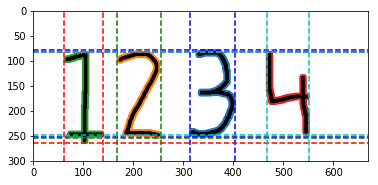

  -  Percentage of crop / entire canvas 7.75%


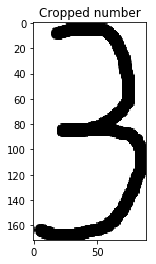

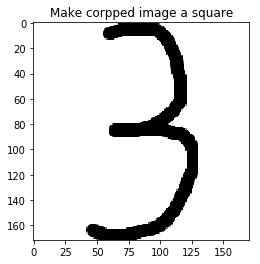

  -  Percentage of crop / entire canvas 7.44%


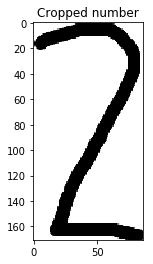

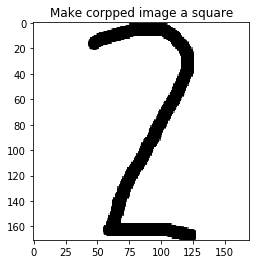

  -  Percentage of crop / entire canvas 7.06%


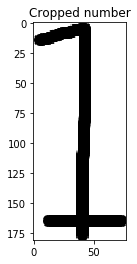

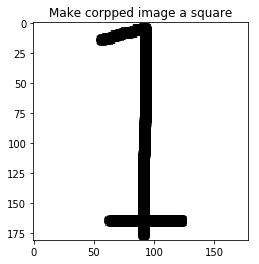

  -  Percentage of crop / entire canvas 6.89%


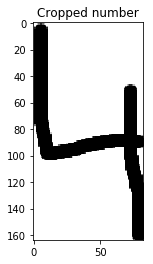

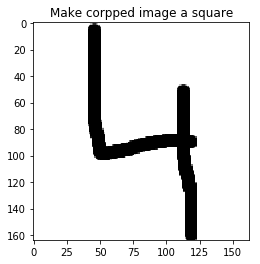

0 contours dropped


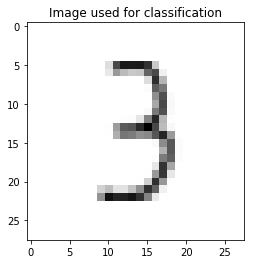

Classified: 3


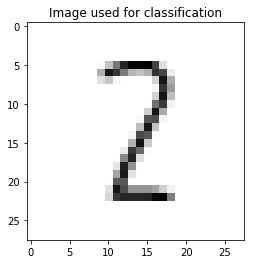

Classified: 2


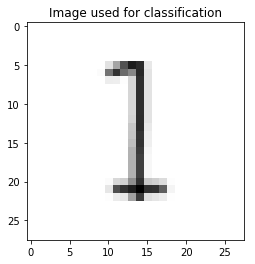

Classified: 1


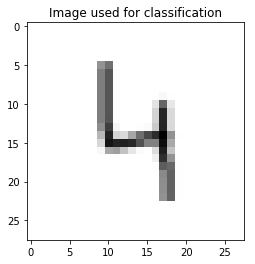

Classified: 4


In [8]:
c.classify()